<a href="https://colab.research.google.com/github/muhammadmo/Internship/blob/main/Opoint_task1(credit_card_number_detection).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"muhammadmoosavi","key":"1fa1bc8aae4bfd517b860f44615ff8d9"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d barbaravanaki/credit-card-number-images

  0% 0.00/9.11M [00:00<?, ?B/s]
100% 9.11M/9.11M [00:00<00:00, 151MB/s]


In [ ]:
from zipfile import ZipFile
file_name = "credit-card-number-images.zip"

with ZipFile(file_name,'r') as zipp:
  zipp.extractall()
print('done') 

done


In [ ]:
pip install split_folders

In [ ]:
import splitfolders
input_folder = "/content/dataset"
output = "/content/splited_dataset"

splitfolders.ratio(input_folder, output=output, seed=42, ratio=(.7, .1, .2)) 


Copying files: 0 files [00:00, ? files/s]
Copying files: 885 files [00:00, 4974.44 files/s]


In [ ]:
import matplotlib.pyplot as plt 
import numpy as np             
import pandas as pd           

train_path = '/content/splited_dataset/train'
test_path = '/content/splited_dataset/test'
valid_path = '/content/splited_dataset/val'

#set defult image size
batch_size = 128
img_width = 256
img_height = 256

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Create Image Data Generator for Train Set
image_gen = ImageDataGenerator(
                                width_shift_range=0.05,
                                height_shift_range=0.05,
                                rescale = 1./255,
                                shear_range = 0.2,
                                zoom_range = 0.2,
                                  horizontal_flip = False,          
                               )
# Create Image Data Generator for Test/Validation Set
test_data_gen = ImageDataGenerator(rescale = 1./255)

In [ ]:
train = image_gen.flow_from_directory(
      train_path,
      target_size=(img_height, img_width),
      color_mode='grayscale',
      class_mode='sparse',
      batch_size=batch_size
      )
test = test_data_gen.flow_from_directory(
      test_path,
      target_size=(img_height, img_width),
      color_mode='grayscale',
      shuffle=False, 
#setting shuffle as False just so we can later compare it with predicted values without having indexing problem 
      class_mode='sparse',
      batch_size=batch_size
      )
valid = test_data_gen.flow_from_directory(
      valid_path,
      target_size=(img_height, img_width),
      color_mode='grayscale',
      class_mode='sparse', 
      batch_size=batch_size
      )


Found 615 images belonging to 11 classes.
Found 185 images belonging to 11 classes.
Found 85 images belonging to 11 classes.


In [ ]:
from tensorflow.keras.applications import EfficientNetB4

conv_base = EfficientNetB4(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

71696384/71686520 [==============================] - 1s 0us/step


In [ ]:
conv_base.summary()

Model: "efficientnetb4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 225, 225, 3)  0           ['normalization[0][0

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,Flatten,MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
#building CNN stracture
cnn = Sequential()
cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Conv2D(64, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Conv2D(128, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Conv2D(128, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Flatten())
cnn.add(Dense(activation = 'relu', units = 128))
cnn.add(Dense(activation = 'relu', units = 64))
cnn.add(Dense(10,activation="softmax"))
cnn.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 128)      0

In [ ]:
#early stopping
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow.keras import callbacks

early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=8)

learning_rate_reduction = ReduceLROnPlateau(monitor='accuracy', patience = 5, verbose=1,factor=0.3, min_lr=0.0001)

checkpoint_filepath = 'checkpointCNN.h5'
model_check = callbacks.ModelCheckpoint(
    checkpoint_filepath, monitor='val_loss', verbos=1, save_best_only = True, mode='auto' 
)

callbacks_list = [ early, learning_rate_reduction, model_check]

In [ ]:


history = cnn.fit(train,
                    batch_size=16,
                    epochs=100,
                    validation_data=valid,
                    callbacks = callbacks_list)

Epoch 1/100
5/5 [==============================] - 5s 887ms/step - loss: 0.0599 - accuracy: 0.9854 - val_loss: 0.6457 - val_accuracy: 0.9176 - lr: 0.0010
Epoch 2/100
5/5 [==============================] - 5s 856ms/step - loss: 0.0380 - accuracy: 0.9935 - val_loss: 0.5987 - val_accuracy: 0.9059 - lr: 0.0010
Epoch 3/100
5/5 [==============================] - 5s 857ms/step - loss: 0.0493 - accuracy: 0.9870 - val_loss: 0.6368 - val_accuracy: 0.9176 - lr: 0.0010
Epoch 4/100
5/5 [==============================] - 5s 860ms/step - loss: 0.0771 - accuracy: 0.9837 - val_loss: 0.6771 - val_accuracy: 0.9059 - lr: 0.0010
Epoch 5/100
5/5 [==============================] - 5s 938ms/step - loss: 0.0462 - accuracy: 0.9854 - val_loss: 0.7830 - val_accuracy: 0.9059 - lr: 0.0010
Epoch 6/100
5/5 [==============================] - 5s 871ms/step - loss: 0.0427 - accuracy: 0.9854 - val_loss: 0.7500 - val_accuracy: 0.9176 - lr: 0.0010
Epoch 7/100
5/5 [==============================] - ETA: 0s - loss: 0.0445 - 

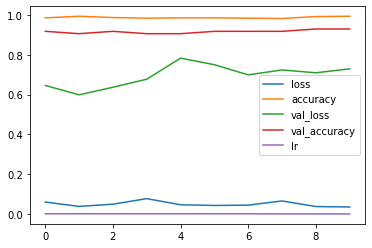

In [ ]:
pd.DataFrame(cnn.history.history).plot()

In [ ]:
test_accu = cnn.evaluate(test)
print('The testing accuracy is :',test_accu[1]*100, '%')

2/2 [==============================] - 0s 100ms/step - loss: 0.3087 - accuracy: 0.9622
The testing accuracy is : 96.21621370315552 %


In [ ]:
from keras.models import load_model  
model = load_model('checkpointCNN.h5')
test_accu = model.evaluate(test) 
print('The testing accuracy is :',test_accu[1]*100, '%')
preds = model.predict(test,verbose=1)

2/2 [==============================] - 1s 90ms/step - loss: 0.2360 - accuracy: 0.9514
The testing accuracy is : 95.13513445854187 %
2/2 [==============================] - 0s 161ms/step


In [ ]:
preds = cnn.predict(test,verbose=1)

2/2 [==============================] - 0s 164ms/step


In [ ]:
import numpy as np
rounded_labels=np.argmax(preds, axis=1)
rounded_labels[1]

0

In [ ]:
from sklearn.metrics import confusion_matrix
cmm = confusion_matrix(rounded_labels, test.classes)
cmm

array([[22,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 19,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0, 17,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 16,  1,  0,  0,  0,  0,  1],
       [ 0,  0,  0,  1, 21,  0,  1,  0,  0,  0],
       [ 0,  0,  0,  0,  0, 24,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0, 15,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 10,  0,  1],
       [ 0,  0,  0,  0,  1,  0,  0,  0, 16,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  1,  0, 18]])

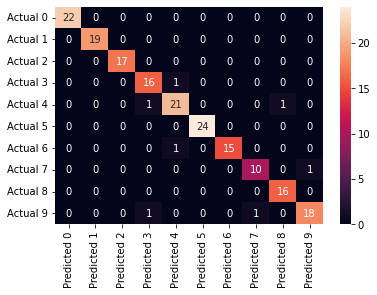

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix
cm = pd.DataFrame(data=confusion_matrix(test.classes, rounded_labels, labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),index=["Actual 0", "Actual 1", "Actual 2", "Actual 3", "Actual 4", "Actual 5", "Actual 6", "Actual 7", "Actual 8", "Actual 9"],
columns=["Predicted 0", "Predicted 1", "Predicted 2", "Predicted 3", "Predicted 4", "Predicted 5", "Predicted 6", "Predicted 7", "Predicted 8", "Predicted 9"])
import seaborn as sns
sns.heatmap(cm,annot=True,fmt="d")

**credit card number detection**

In [1]:
import numpy as np
import cv2
from imutils import contours
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#Location of credit card
predict_card = "card-6.jpg"
#Location of template
template = "card-test-2.jpg"

In [3]:
#Specify credit card type
FIRST_NUMBER = {
  "3": "American Express",
  "4": "Visa",
  "5": "MasterCard",
  "6": "Discover Card"
}

In [13]:
#Define some function functions

#Sort boxes
def sort_contours(cnts, method="left-to-right"):
  reverse = False
  i = 0

  if method == "right-to-left" or method == "bottom-to-top":
    reverse = True

  if method == "top-to-bottom" or method == "bottom-to-top":
    i = 1
  Boundingboxes = [cv2.boundingRect(c) for c in cnts] # use the smallest rectangle to wrap the found shape x, y, h, W
  (cnts, boundingBoxes) = zip(*sorted(zip(cnts, Boundingboxes),
                    key=lambda b: b[1][i], reverse=reverse))

  return cnts, boundingBoxes

#Resizing pictures
def resize(image, width=None, height=None, inter=cv2.INTER_AREA):
  dim = None
  (h, w) = image.shape[:2]
  if width is None and height is None:
    return image
  if width is None:
    r = height / float(h)
    dim = (int(w * r), height)
  else:
    r = width / float(w)
    dim = (width, int(h * r))
  resized = cv2.resize(image, dim, interpolation=inter)
  return resized

#Define CV2 display function
def cv_show(name,img):
  cv2.imshow(name,img)
  cv2.waitKey(0)
  cv2.destroyAllWindows()

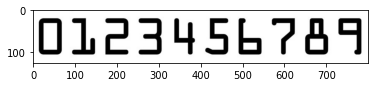

In [5]:
#Read template image
img = cv2.imread(template)
#cv_show("img",img)
plt.imshow(img)

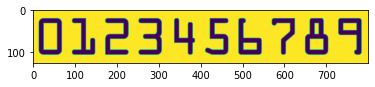

In [6]:
#Convert to grayscale
ref = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
#cv_show("ref",ref)
plt.imshow(ref)

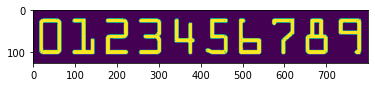

In [7]:
ref = cv2.threshold(ref,10,255,cv2.THRESH_BINARY_INV)[1]
#cv_show("ref",ref)
plt.imshow(ref)

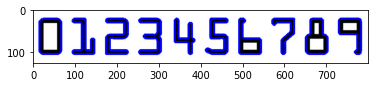

In [9]:
#The parameter of CV2. Findcontours() function is binary image, that is, black and white (not gray image), CV2. Retr_ External only detects contour, cv2.chain_ APPROX_ Simple only keeps the coordinates of the end point
#Each element in the returned list is an outline in the image
#Calculate the contour in the binary image
refCnts,hierarchy = cv2.findContours(ref.copy(),cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
#Draw an outline on the original picture
cv2.drawContours(img,refCnts,-1,(0,0,255),3)
#cv_show("img",img)
plt.imshow(img)

In [14]:
print(np.array(refCnts).shape)
#Sort, left to right, top to bottom
refCnts = sort_contours(refCnts,method="left-to-right")[0] 
digits = {}

#Traverse every contour
for (i, c) in enumerate(refCnts):
  #Calculate the bounding rectangle and reshape it to the right size
  (x, y, w, h) = cv2.boundingRect(c)
  roi = ref[y:y + h, x:x + w]
  roi = cv2.resize(roi, (57, 88))

  #Each number corresponds to each template
  digits[i] = roi

(10,)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """Entry point for launching an IPython kernel.


In [15]:
rectKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 3))
sqKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))

In [16]:
def cv_show(name,img):
  cv2.imshow(name,img)
  cv2.waitKey(0)
  cv2.destroyAllWindows()

#Resizing pictures
def resize(image, width=None, height=None, inter=cv2.INTER_AREA):
  dim = None
  (h, w) = image.shape[:2]
  if width is None and height is None:
    return image
  if width is None:
    r = height / float(h)
    dim = (int(w * r), height)
  else:
    r = width / float(w)
    dim = (width, int(h * r))
  resized = cv2.resize(image, dim, interpolation=inter)
  return resized



print(np.array(refCnts).shape)
#Sort, left to right, top to bottom
refCnts = sort_contours(refCnts,method="left-to-right")[0] 
digits = {}

#Traverse every contour
for (i, c) in enumerate(refCnts):
  #Calculate the bounding rectangle and reshape it to the right size
  (x, y, w, h) = cv2.boundingRect(c)
  roi = ref[y:y + h, x:x + w]
  roi = cv2.resize(roi, (57, 88))

  #Each number corresponds to each template
  digits[i] = roi

(10,)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


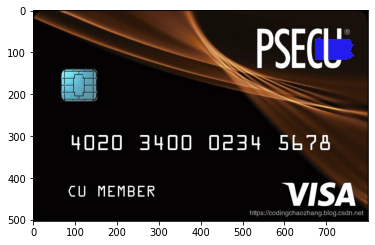

In [17]:
image = cv2.imread('card-6.jpg')
#cv_show("image",image)
plt.imshow(image)

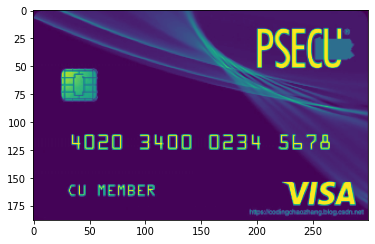

In [19]:
#First, the image is resized
image = resize(image,width=300)
#Gray processing
gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
#cv_show("gray",gray)
plt.imshow(gray)

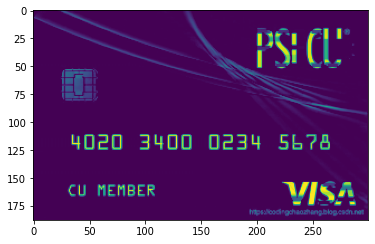

In [20]:
tophat = cv2.morphologyEx(gray,cv2.MORPH_TOPHAT,rectKernel)
#cv_show("tophat",tophat)
plt.imshow(tophat)

(188, 300)


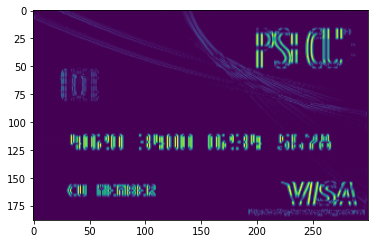

In [21]:
gradX = cv2.Sobel(tophat, ddepth=cv2.CV_32F, dx=1, dy=0, ksize=-1)
gradX = np.absolute(gradX)
(minVal, maxVal) = (np.min(gradX), np.max(gradX))
gradX = (255 * ((gradX - minVal) / (maxVal - minVal)))
gradX = gradX.astype("uint8")
print (np.array(gradX).shape)
#cv_show("gradX",gradX)
plt.imshow(gradX)

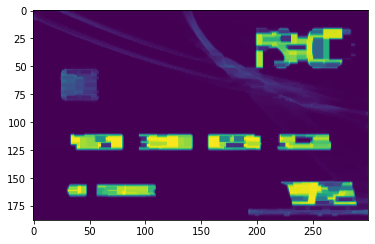

In [22]:
gradX = cv2.morphologyEx(gradX, cv2.MORPH_CLOSE, rectKernel) 
#cv_show("gradX",gradX)
plt.imshow(gradX)

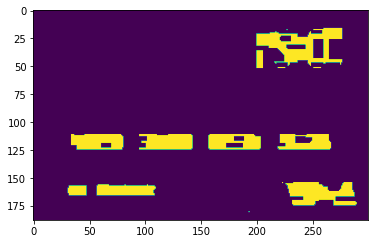

In [23]:
#THRESH_ Otsu will automatically find the appropriate threshold, suitable for bimodal, the threshold parameter needs to be set to 0
thresh = cv2.threshold(gradX, 0, 255,cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1] 
#cv_show("thresh",thresh)
plt.imshow(thresh)

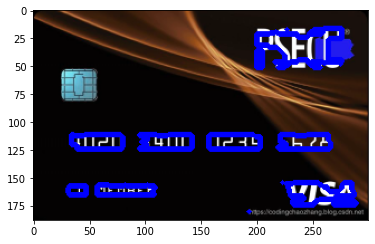

In [24]:
threshCnts, hierarchy = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
cnts = threshCnts
cur_img = image.copy()
cv2.drawContours(cur_img,cnts,-1,(0,0,255),3) 
#cv_show("img",cur_img)
plt.imshow(cur_img)

In [25]:
locs = []

for (i, c) in enumerate(cnts):
  (x, y, w, h) = cv2.boundingRect(c)
  ar = w / float(h)

  if ar > 2.5 and ar < 4.0:
    if (w > 40 and w < 55) and (h > 10 and h < 20):
      locs.append((x, y, w, h))

locs = sorted(locs, key=lambda x:x[0])
output = []

In [26]:
for (i, (gX, gY, gW, gH)) in enumerate(locs):
  groupOutput = []

  group = gray[gY - 5:gY + gH + 5, gX - 5:gX + gW + 5]
  #cv_show("group",group)

  group = cv2.threshold(group, 0, 255,cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
  #cv_show("group",group)

  digitCnts,hierarchy = cv2.findContours(group.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
  digitCnts = contours.sort_contours(digitCnts,method="left-to-right")[0]

  for c in digitCnts:
    (x, y, w, h) = cv2.boundingRect(c)
    roi = group[y:y + h, x:x + w]
    roi = cv2.resize(roi, (57, 88))
    #cv_show("roi",roi)
    

    
    scores = []
    for (digit, digitROI) in digits.items():
      result = cv2.matchTemplate(roi, digitROI,cv2.TM_CCOEFF)
      (_, score, _, _) = cv2.minMaxLoc(result)
      scores.append(score)

    groupOutput.append(str(np.argmax(scores)))

  cv2.rectangle(image, (gX - 5, gY - 5),(gX + gW + 5, gY + gH + 5), (0, 0, 255), 1)
  cv2.putText(image, "".join(groupOutput), (gX, gY - 15),cv2.FONT_HERSHEY_SIMPLEX, 0.65, (0, 0, 255), 2)

  output.extend(groupOutput)

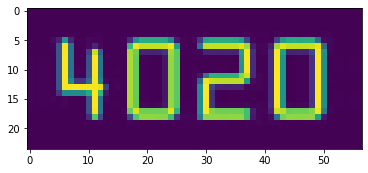

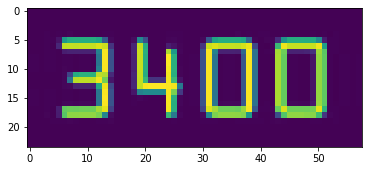

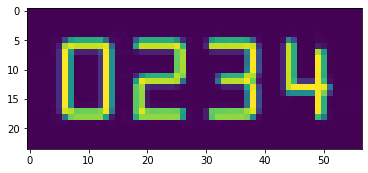

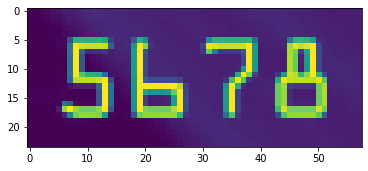

In [27]:
from PIL import Image
digit_num=0
lst=[]
for (i, (gX, gY, gW, gH)) in enumerate(locs):
    groupOutput = []
    group = gray[gY - 5:gY + gH + 5, gX - 5:gX + gW + 5]
    plt.imshow(group, interpolation='nearest')
    plt.show()
 
    im = Image.fromarray(group)
    im.save("group"+str(digit_num)+".png")
    lst.append("group"+str(digit_num)+".png")
    digit_num+=1

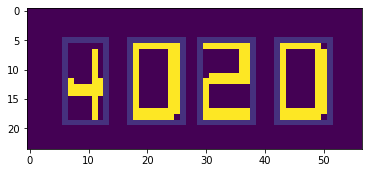

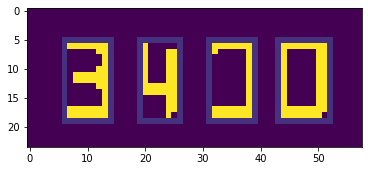

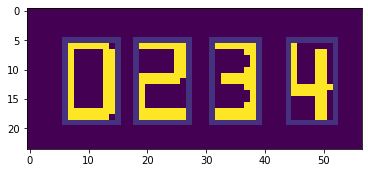

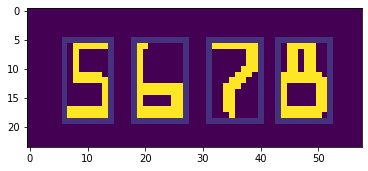

In [28]:
lst_digits_name=[]
for i in range(len(lst)):
  image = cv2.imread(lst[i])
  copy = image.copy()

  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  thresh = cv2.threshold(gray,0,255,cv2.THRESH_OTSU + cv2.THRESH_BINARY)[1]

  cnts = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  cnts = cnts[0] if len(cnts) == 2 else cnts[1]
  if i==0:
      ROI_number = 1
  elif i==1:
      ROI_number = 5
  elif i==2:
      ROI_number =9
  else :
      ROI_number = 13

  for c in cnts:
      x,y,w,h = cv2.boundingRect(c)
      ROI = image[y:y+h, x:x+w]
      cv2.imwrite('ROI_{}.png'.format(ROI_number), ROI)
      lst_digits_name.append('ROI_{}.png'.format(ROI_number))
      cv2.rectangle(thresh,(x,y),(x+w,y+h),(36,255,12),0)
      ROI_number += 1
  plt.imshow(thresh, interpolation='nearest')
  plt.show()


OSError: ignored